In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('../data/out/data.pkl')
df

,name,date,revenue,runtime,languages,countries,genres,summary,phrases
0,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",The scene is all filmed from a stationary came...,"[anvil, beer, blacksmith, camera, metal]"
1,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",After finding out that her father is suffering...,"[editor, falls, financial problems, hamilton, ..."
2,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",James J. Corbett and Peter Courtney both take ...,"[boxing, hero]"
3,La Mer,1895-01-01,NaN,0.633333,[Silent film],[France],"[Black-and-white, Documentary, Indie, Short, S...",This 38 second film has a very simple plot in ...,"[film, jetty, water]"
4,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Animation, Comedy, Indie, Short, Silent]",The film consists of a series of animations on...,"[beach, boat, diving, dog, film, play, swimmin..."
...,...,...,...,...,...,...,...,...,...
42193,Kisaragi,NaT,NaN,108.000000,[],[],"[Comedy, Mystery]",One year after the suicide of C-list model Kis...,"[death, model, suicide, talk]"
42194,Mother Fish,NaT,NaN,92.000000,[Vietnamese],[],[Drama],Mother Fish follows the story of a middle-aged...,"[boat, death, engine, fish, food, imdb, led, m..."
42195,Deewana Tere Naam Ka,NaT,NaN,140.000000,[Hindi],[],[Drama],"Deewana Tere Naam Ka is a family drama, featur...","[danny denzongpa, drama, family, jagdeep, lead..."
42196,Hunter Prey,NaT,NaN,90.000000,[],[],[Science Fiction],A group of elite interstellar commandos crash ...,"[ai, bit, bounty hunter, breaks loose, command..."


### Genres column exploration

In [3]:
genres = df['genres'].dropna()

In [4]:
# total number of genres
genres.explode().nunique()

343

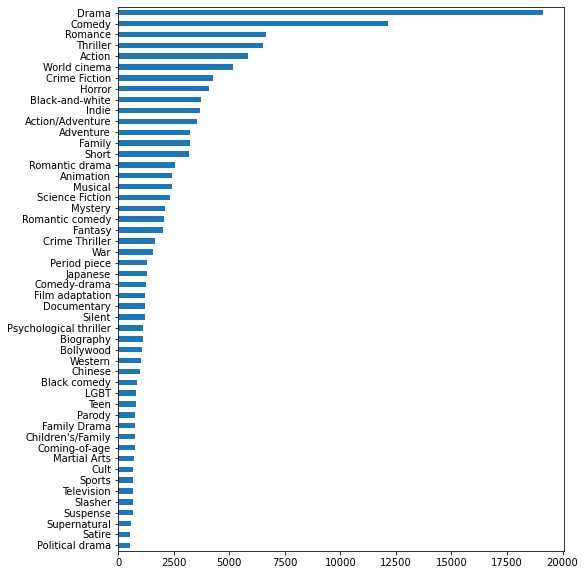

In [5]:
#distribution of top 50 common genres
dist = genres.explode().value_counts(ascending = True)
dist[-50:].plot(kind = 'barh',figsize = (8,10))

In [6]:
df = df.dropna(subset = ['genres'])

### Baseline model

In [7]:
def summary_preprocessing(plot):
    
    #remove punctuation
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punct = plot.apply(lambda x: tokenizer.tokenize(x))
    
    #remove stopwords
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    no_stopwords = no_punct.apply(lambda x: ' '.join([w for w in x if w not in stop_words]))
    
    return no_stopwords

In [8]:
def genre_to_label(genres):
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(df['genres'])
    y = multilabel_binarizer.transform(df['genres'])
    return y

In [9]:
def model(summary,label):
    #tf-idf vectorizer
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(df['genres'])
    label = multilabel_binarizer.transform(df['genres'])
    xtrain, xval, ytrain, yval = train_test_split(summary, label, test_size=0.2, random_state=9)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xval_tfidf = tfidf_vectorizer.transform(xval)
    
    #OneVsRest classifier
    lr = sklearn.linear_model.LogisticRegression()
    clf = OneVsRestClassifier(lr,n_jobs = 8)
#     scores = cross_validate(clf, xtrain_tfidf, ytrain, scoring=scoring)
    clf.fit(xtrain_tfidf,ytrain)
    y_pred = clf.predict(xval_tfidf)
    
    
    #evaluation
#     f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")
    return multilabel_binarizer.inverse_transform(yval), multilabel_binarizer.inverse_transform(y_pred)

In [10]:
df['processed_summary'] = summary_preprocessing(df['summary'])
labels = genre_to_label(df['genres'])
genre_summary, predict_genre_summary = model(df['processed_summary'],labels)

[nltk_data] Downloading package stopwords to
[nltk_data]     /datasets/home/66/266/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
phrases_joined = df['phrases'].apply(lambda x: ' '.join(x))
genre_phrase, predict_genre_phrase = model(phrases_joined,labels)

In [12]:
#f1_score_summary,f1_score_phrase

In [13]:
predict_genre_summary

[('Comedy', 'Drama'),
 (),
 (),
 ('Horror',),
 (),
 ('Horror', 'Slasher'),
 ('Comedy',),
 ('Comedy',),
 ('Comedy',),
 ('Horror',),
 ('Drama', 'Romance'),
 ('Drama',),
 ('Comedy',),
 ('Action', 'Horror'),
 ('Drama', 'Romance'),
 ('Comedy',),
 (),
 ('Comedy', 'Drama', 'Romance'),
 ('Action', 'Adventure'),
 (),
 (),
 ('Drama',),
 ('Mystery', 'Thriller'),
 ('Black-and-white', 'Comedy', 'Romance'),
 (),
 ('Comedy',),
 ('Drama',),
 ('Drama', 'Romance'),
 ('Drama',),
 (),
 (),
 ('Action', 'Crime Fiction', 'Crime Thriller', 'Drama', 'Mystery', 'Thriller'),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Horror',),
 ('Drama',),
 ('Action/Adventure',),
 ('Documentary',),
 (),
 ('Thriller',),
 ('Action', 'Action/Adventure', 'Western'),
 ('Adventure', 'Thriller'),
 (),
 ('Comedy',),
 ('Drama', 'Romance'),
 (),
 ('Comedy',),
 ('Drama',),
 (),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Horror', 'Thriller'),
 ('Drama', 'Japanese', 'World cinema'),
 (),
 (),
 (),
 ('Comedy',),
 ('Dra

In [14]:
predict_genre_phrase

[('Drama',),
 (),
 (),
 (),
 ('Adventure', 'Fantasy'),
 ('Comedy',),
 ('Comedy',),
 (),
 (),
 ('Horror',),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 (),
 ('Drama',),
 (),
 ('Animation', 'Short'),
 ('Comedy', 'Drama', 'Romance'),
 ('Action', 'Action/Adventure'),
 (),
 (),
 ('Drama',),
 (),
 ('Romance',),
 (),
 (),
 (),
 ('Drama',),
 ('Drama',),
 (),
 ('Action', 'Science Fiction', 'Thriller'),
 ('Action', 'Crime Fiction', 'Crime Thriller', 'Drama', 'Thriller'),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 (),
 ('Horror',),
 (),
 ('Action/Adventure',),
 ('Documentary',),
 (),
 ('Crime Fiction', 'Drama', 'Thriller'),
 ('Action', 'Action/Adventure', 'Western'),
 (),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Adventure',),
 ('Adventure', 'Comedy'),
 ('Comedy', 'Romance'),
 ('Drama',),
 ('Drama',),
 ('Horror', 'Thriller'),
 ('Drama', 'World cinema'),
 ('Comedy',),
 (),
 ('Drama',),
 ('Comedy', 'Drama'),
 (),
 (),
 ('Drama',),
 (),
 ('Action', '

### Evaluation metrics

#### percentage of labels that were predicted correctly

In [15]:
total_label = sum(genres.apply(len))
total_label

149300

In [16]:
np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))])/total_label

0.039772270596115204

In [17]:
np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))])/total_label

0.042505023442732756

In [37]:
summary_left_out = pd.Series(list(set(b).intersection(a)) for a, b in zip(pd.Series(predict_genre_summary), \
                                                                pd.Series(genre_summary))).explode().value_counts()
phrase_left_out = pd.Series(list(set(b).intersection(a)) for a, b in zip(pd.Series(predict_genre_phrase), \
                                                                pd.Series(genre_phrase))).explode().value_counts()

dstr = pd.Series(genre_summary).explode().value_counts()

In [41]:
left_out_pctg = (summary_left_out/dstr)
left_out_pctg_phrase = (phrase_left_out/dstr)
left_out_pctg.loc[~left_out_pctg.isnull()].rename('summary_pctg').to_frame().merge(left_out_pctg_phrase.rename('phrase_pctg'),how = 'left',left_index = True, right_index = True)\
.merge(dstr.rename('dstr'),how = 'left',left_index = True,right_index = True).sort_values(ascending = False,by = 'summary_pctg')

,summary_pctg,phrase_pctg,dstr
Drama,0.655065,0.637922,3850
Comedy,0.418807,0.335543,2414
Horror,0.412736,0.383255,848
Short,0.347896,0.339806,618
War,0.330097,0.297735,309
Animation,0.301031,0.280412,485
Science Fiction,0.276498,0.267281,434
Thriller,0.272209,0.246944,1227
Action,0.270175,0.256140,1140
Documentary,0.251938,0.135659,258
